# SEVERSTAL CLASSIFICATION

# Imports

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2
import keras.backend as K

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import plotly.graph_objects as go

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [3]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, Conv2DTranspose, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape, UpSampling2D, Convolution2DTranspose
from tensorflow.keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix, f1_score, classification_report
from sklearn.metrics import mean_absolute_error

In [5]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.8.0
Keras Version: 2.8.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!nvidia-smi

Thu Jun  9 13:09:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.95       Driver Version: 512.95       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8    40W / 350W |   3120MiB / 12288MiB |     43%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
sys.path.append('../E-CNN-classifier-main/libs')
import ds_layer #Dempster-Shafer layer
import utility_layer_train #Utility layer for training
import utility_layer_test #Utility layer for training
import AU_imprecision #Metric average utility for set-valued classification

## Paths

In [9]:
# pathTrainImgs = Path('../DB/train_images/')
pathTrainImgs = Path('../DB/cropped_train_images/')
# pathTrainImgsLabels = Path('../DB/train_images_masks/')
pathTrainImgsLabels = Path('../DB/cropped_train_images_masks/')
# cvsPath = Path('../DB/train.csv')
cvsPath = Path('../DB/cropped_train.csv')

In [10]:
checkpointPath = Path('../Outputs/CNN/CHECKPOINTS/CROPPED-DB/')
graphPath = Path('../Outputs/CNN/GRAPHS/CROPPED-DB/')
pathSavedModel = Path('../Outputs/CNN/MODELS-PB/CROPPED-DB/')
plotpath = Path('../Outputs/CNN/PLTS/CROPPED-DB/')
evalspath = Path('../Outputs/CNN/EVALUATIONS/CROPPED-DB/')

In [11]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)
evalspath.mkdir(parents=True, exist_ok=True)

## Random Seed

In [12]:
SEED = 42

## Global Variables

In [13]:
# IMAGE_SIZE = [1600,256] #original size
IMAGE_SIZE = [256,1600] #original size
IMAGE_SIZE = [256,160] #original size CROPPED
# IMAGE_SIZE = [256,1024]
# IMAGE_SIZE = [256,512]
# IMAGE_SIZE = [256,256]
# IMAGE_SIZE = [128,256]
# IMAGE_SIZE = [64,128]
# IMAGE_SIZE = [1024,256]
IMAGE_RESIZE = [256,800]
CLASS_NAMES = [0,1,2,3,4]

NUMBER_SLICES = 10

## Utilities

In [14]:
def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        # plt.plot(history.history[met])
        # plt.plot(history.history['val_'+met])
        # plt.title('model '+nameOfModelGraph+ met)
        # plt.ylabel(met)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
            # plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met + '.png'),dpi=dpi)
        plt.show()

In [15]:
def loadPNGtoArray(paths,basePath, outSize = IMAGE_SIZE, resize = True):
    imgs = []
    for p in tqdm(paths):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = basePath / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(outSize[0],outSize[1]))
        else:
            img = load_img(fullPath)

        
        img = img_to_array(img) / 255.0
        
        imgs.append(img)
    imgs = np.array([np.array(fname) for fname in imgs])  #transform each element of list in numpy array
    return imgs

In [16]:
def sliceArrays(inputArray,ns = 10):
    outArray = np.zeros((inputArray.shape[0]*ns,inputArray.shape[1],int(inputArray.shape[2]/ns),inputArray.shape[3])).astype('float32')
    # print(outArray.shape)
    count = 0
    for im in inputArray:
        for i in range(ns):
            m = int(i * (inputArray.shape[2]/ns))
            j = int((i+1) * (inputArray.shape[2]/ns))
            # print(m)
            # print(j)
            outArray[count*ns+i] = im[:,m:j,:]
        count = count + 1

    return outArray

In [17]:
#cropping of images in numpy array
def cropNpArrayIm(npArray,h_w): #sqare crop h = w = h_w
    outArray = np.empty((0,npArray.shape[1],h_w,3));
    #here a for is used to take each image of the array and crop using the numpy function array_split on each axis
    for im in npArray:
        # imageCropX = np.array(np.array_split(im,int(npArray.shape[1]/h_w),axis=0));             #the image is split in (shape[1]/h_w) parts horizontally
        imageCropY = np.array(np.array_split(im,int(npArray.shape[2]/h_w),axis=1));     #the images resulted from the firts split are split in (shape[2]/h_w) parts vertically
        # imageCropY = np.concatenate(imageCropY, axis=0)                                         #the cropped images are concatenated to result a single array
        outArray = np.concatenate((outArray,imageCropY),axis=0)                                 #the out array is fulled by the images
    return outArray

# Inputs

In [18]:
# read in all our data
SevDB = pd.read_csv(cvsPath)

In [19]:
SevDB.head()

,Unnamed: 0,PathId,Has_Defect,Kind_Defect
0,0,0002cc93b_0.jpg,True,1
1,1,0002cc93b_1.jpg,True,1
2,2,0002cc93b_2.jpg,True,1
3,3,0002cc93b_3.jpg,False,0
4,4,0002cc93b_4.jpg,True,1


In [21]:
mapping = {}
for x in range(len(CLASS_NAMES)):
    mapping[CLASS_NAMES[x]] = x



# takename = copy.deepcopy(SevDB['ClassId'])
takename = copy.deepcopy(SevDB['Kind_Defect'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)

i = 0
for n in CLASS_NAMES:
    SevDB[str('Error_Class_'+str(n))] = one_h_enc[:,i]
    i = i+1

In [21]:
nan_indices = SevDB.index[SevDB['Has_Defect'] != True]


SevDB.drop(nan_indices[:int(len(nan_indices) * 0.6)], inplace=True)   #to create a new DataFrame, if you want to modify the original one, put inplace=True

In [22]:
# X_full = pd.DataFrame(SevDB[['ImageId']])
X_full = pd.DataFrame(SevDB[['PathId']])

# Y_full = pd.DataFrame(SevDB[['Error_Class_1','Error_Class_2','Error_Class_3','Error_Class_4']])
Y_full = pd.DataFrame(SevDB[['Error_Class_0','Error_Class_1','Error_Class_2','Error_Class_3','Error_Class_4']])     # error_class_0 means there is no error

In [23]:
class1 = Y_full.sum()[0]
print('ErrorClass0 (not error): ' + str(class1))
class2 = Y_full.sum()[1]
print('ErrorClass1: ' + str(class2))
class3 = Y_full.sum()[2]
print('ErrorClass2: ' + str(class3))
class4 = Y_full.sum()[3]
print('ErrorClass3: ' + str(class4))
class4 = Y_full.sum()[4]
print('ErrorClass4: ' + str(class4))
total = Y_full.sum().sum()
print('total errors: ' + str(total))

ErrorClass0 (not error): 92704.0
ErrorClass1: 3726.0
ErrorClass2: 514.0
ErrorClass3: 32506.0
ErrorClass4: 3870.0
total errors: 133320.0


In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.05,shuffle=True, random_state=SEED) #SEED
X_train, X_val, Y_train, Y_val = train_test_split(X_val,Y_val, test_size=0.2,shuffle=True, random_state=SEED) #SEED
# X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.2,shuffle=True)

In [25]:
class1 = Y_train.sum()[0]
print('ErrorClass0 (not error): ' + str(class1))
class2 = Y_train.sum()[1]
print('ErrorClass1: ' + str(class2))
class3 = Y_train.sum()[2]
print('ErrorClass2: ' + str(class3))
class4 = Y_train.sum()[3]
print('ErrorClass3: ' + str(class4))
class4 = Y_train.sum()[4]
print('ErrorClass4: ' + str(class4))
total = Y_train.sum().sum()
print('total errors: ' + str(total))

ErrorClass0 (not error): 1488.0
ErrorClass1: 140.0
ErrorClass2: 20.0
ErrorClass3: 1290.0
ErrorClass4: 170.0
total errors: 3108.0


## IMPORT IMGS

In [26]:
# X_train_IMGS = loadPNGtoArray(X_train['ImageId'],basePath=pathTrainImgs)
# Y_train_IMGS = loadPNGtoArray(X_train['ImageId'],basePath=pathTrainImgsLabels)
# X_val_IMGS = loadPNGtoArray(X_val['ImageId'],basePath=pathTrainImgs)
# Y_val_IMGS = loadPNGtoArray(X_val['ImageId'],basePath=pathTrainImgsLabels)
X_train_IMGS = loadPNGtoArray(X_train['PathId'],basePath=pathTrainImgs)
Y_train_IMGS = loadPNGtoArray(X_train['PathId'],basePath=pathTrainImgsLabels)
X_val_IMGS = loadPNGtoArray(X_val['PathId'],basePath=pathTrainImgs)
Y_val_IMGS = loadPNGtoArray(X_val['PathId'],basePath=pathTrainImgsLabels)

100%|██████████| 777/777 [00:00<00:00, 2447.67it/s]


In [27]:
# # normalization done on the run when loaded
# X_train_IMGS = X_train_IMGS.astype('float32')/255.0
# Y_train_IMGS = Y_train_IMGS.astype('float32')/255.0
# X_val_IMGS = X_val_IMGS.astype('float32')/255.0
# Y_val_IMGS = Y_val_IMGS.astype('float32')/255.0

In [28]:
print(X_val_IMGS.shape)

print(X_val_IMGS.dtype)
print(X_val_IMGS.shape)
print(X_val_IMGS[0].dtype)
print(X_val_IMGS[0].shape)

(777, 256, 160, 3)
float32
(777, 256, 160, 3)
float32
(256, 160, 3)


In [29]:
print(X_val_IMGS[0])

[[[0.48235294 0.48235294 0.48235294]
  [0.46666667 0.46666667 0.46666667]
  [0.44705883 0.44705883 0.44705883]
  ...
  [0.4627451  0.4627451  0.4627451 ]
  [0.42745098 0.42745098 0.42745098]
  [0.45882353 0.45882353 0.45882353]]

 [[0.4745098  0.4745098  0.4745098 ]
  [0.4745098  0.4745098  0.4745098 ]
  [0.47058824 0.47058824 0.47058824]
  ...
  [0.49019608 0.49019608 0.49019608]
  [0.4745098  0.4745098  0.4745098 ]
  [0.49019608 0.49019608 0.49019608]]

 [[0.4745098  0.4745098  0.4745098 ]
  [0.49019608 0.49019608 0.49019608]
  [0.5058824  0.5058824  0.5058824 ]
  ...
  [0.49411765 0.49411765 0.49411765]
  [0.50980395 0.50980395 0.50980395]
  [0.49803922 0.49803922 0.49803922]]

 ...

 [[0.9647059  0.9647059  0.9647059 ]
  [0.9490196  0.9490196  0.9490196 ]
  [0.92941177 0.92941177 0.92941177]
  ...
  [0.8039216  0.8039216  0.8039216 ]
  [0.77254903 0.77254903 0.77254903]
  [0.78431374 0.78431374 0.78431374]]

 [[0.96862745 0.96862745 0.96862745]
  [0.9607843  0.9607843  0.9607843 ]


In [30]:
# X_train_IMGS = cropNpArrayIm(X_train_IMGS,160)
# Y_train_IMGS = cropNpArrayIm(Y_train_IMGS,160)
# X_val_IMGS = cropNpArrayIm(X_val_IMGS,160)
# Y_val_IMGS = cropNpArrayIm(Y_val_IMGS,160)

In [31]:
# imagePaths= Path('../DB/GC10-DET/images/images/')

# # 2048 x 1000

# trainset = tf.keras.utils.image_dataset_from_directory(imagePaths,batch_size=32,image_size=(512,512),label_mode='categorical',shuffle=True,seed=SEED,validation_split=0.2,subset='training')
# valset = tf.keras.utils.image_dataset_from_directory(imagePaths,batch_size=32,image_size=(512,512),label_mode='categorical',shuffle=True,seed=SEED,validation_split=0.2,subset='validation')

In [32]:
print(X_train_IMGS.shape)
print(X_val_IMGS.shape)

(3108, 256, 160, 3)
(777, 256, 160, 3)


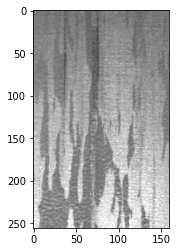

In [33]:
plt.figure()
plt.imshow(X_val_IMGS[0])

In [34]:
Y_val_IMGS = Y_val_IMGS[:,:,:,:1]
Y_train_IMGS = Y_train_IMGS[:,:,:,:1]

In [35]:
print(Y_train_IMGS.shape)

(3108, 256, 160, 1)


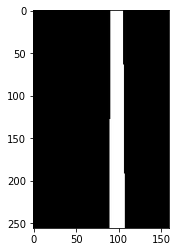

In [36]:
plt.figure()
plt.imshow(Y_train_IMGS[0],cmap='gray')

## MODELS DEFINITION AND USE

### CNN Multi layer fusion CONCATENATION

In [37]:
def ResFBlock(x,filt,kernel,stride):
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    # x = Dropout(0.6)(x)
    return x

In [38]:
# Backup code for Multilayer fusion (CONCATENATION)
def MultiLayerFusionConc(inputShape = (224,224,3), lastActivation = 'sigmoid'):
    inputs = Input(shape=inputShape)
    # x = Rescaling(1.0 / 255)(inputs)

    x = ResFBlock(inputs,16,5,2)
    
    block1 = ResFBlock(x,32,3,2)
    block1 = ResFBlock(block1,32,3,1)
    # block1 = Dropout(0.7)(block1)
    b1_pass = ResFBlock(x,32,1,2)
    # b1_pass = Dropout(0.7)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    
    block1 = Flatten()(block1)
    block2 = Flatten()(block2)
    block3 = Flatten()(block3)
    block4 = Flatten()(block4)
    block5 = Flatten()(block5)
    
    massFusion = Concatenate()([block1,block2,block3,block4,block5])

    outputs = Dense(32, activation='relu')(massFusion)
    outputs = Dense(16, activation='relu')(outputs)


    outputs = Dense(10, activation=lastActivation)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [39]:
# MLConcat = MultiLayerFusionConc((IMAGE_SIZE[0],IMAGE_SIZE[1],3), lastActivation='softmax')

In [40]:
# MLConcat.summary()

In [41]:
# plot_model(MLConcat, to_file=plotpath / Path('MultilayerFusion_CONCAT_model_plot.png'), show_shapes=True, show_layer_names=True)

In [42]:
# METRS = [
# #     tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
#     # tf.keras.metrics.Accuracy(name='accuracy'),
#     tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
# #     tf.keras.metrics.Precision(name="precision"),
# #     tf.keras.metrics.Recall(name="recall"),
# #     tf.keras.metrics.TruePositives(name="True_Positives"),
# #     tf.keras.metrics.TrueNegatives(name="True_Negatives"),
# #     tf.keras.metrics.FalsePositives(name="False_Positives"),
# #     tf.keras.metrics.FalseNegatives(name="False_Negatives"),
# ]

# MLConcat.compile(
#         # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
#         optimizer='adam',
#         # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
#         loss="categorical_crossentropy",
#         metrics=METRS,
# )

# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						checkpointPath / Path('model_CONCAT_callback_CONCAT'), 
# 						monitor='val_categorical_accuracy', verbose=0, 
# 						save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# # history = MLConcat.fit(
# #         x = X_train_IMGS,
# #         y = Y_train,
# #         epochs = 300,
# #         validation_data = [X_val_IMGS,Y_val],
# #         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# #         batch_size= 32,
# # )

# history = MLConcat.fit(
#         x = trainset,
#         epochs = 300,
#         validation_data = valset,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
#         batch_size= 32,
#         # class_weight= class_weights
# )

In [43]:
        
# printAndSaveGraphs(graphPath,'multiLayer_fusion_CONCATENATE_new',history=history, Metrics=METRS)
# hist_df = pd.DataFrame(history.history)
# # or save to csv: 
# hist_csv_file = graphPath / 'history_multiLayer_fusion_CONCATENATE.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)
# MLConcat.save(pathSavedModel / 'multiLayer_fusion_CONCATENATE_new')

In [44]:
# bestPt = checkpointPath / Path('model_CONCAT_callback_CONCAT')
# model = tf.keras.models.load_model(bestPt)

In [45]:


# # evaluation = model.evaluate(X_val_IMGS, Y_val)

# # preds = model.predict(X_val_IMGS)

# # # print(preds)

# # ypreds = np.argmax(preds, axis=1)
# # print(ypreds)

# # yground = np.argmax(Y_val.to_numpy(), axis=1)
# # print(yground)

# # # ypreds = np.array([])
# # # yground = np.array([])


# evaluation = model.evaluate(valset)
# preds = model.predict(valset)

# ypreds = np.array([])
# yground = np.array([])

# for x,y in valset:
#     ypreds = np.concatenate([ypreds, np.argmax(model.predict(x), axis=-1)])
#     yground = np.concatenate([yground, np.argmax(y.numpy(), axis=-1)])

# print(ypreds)
# print(yground)



# score = accuracy_score(yground, ypreds)
# print('accuracy: ', score)

# c_matrix = confusion_matrix(yground, ypreds)
# print('confusion matrix: ', c_matrix)

# c_report = classification_report(yground,ypreds,digits=4)
# print('classification Report: ',c_report)

# evaluation = dict(zip(model.metrics_names,evaluation))
# # print(evaluation)


# with open('../Outputs/CNN/EVALUATIONS/CNN_CONCAT_NY.txt', 'w') as f:
#     f.write('CNN concat on NY KERAS METRICS'+'\n\n')
#     for k, v in evaluation.items():
#         f.write(str(k) + ' >>> '+ str(v) + '\n\n')
#     f.write('CNN concat on NY'+'\n\n')
#     f.write('SKLEARN METRICS:\n\n')
#     # f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
#     f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
#     # f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
#     # f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
#     # f.write(str('F1 score') + ' >>> '+ str(F1) + '\n\n')
#     f.write(str('Confusion Matrix') + ' >>> \n'+ str(c_matrix) + '\n\n')
#     f.write(str('Classification Report') + '\n >>> \n'+ str(c_report) + '\n\n')

### CNN Multi layer fusion DEMPSTER SHAFER

In [46]:
prototypes = 20
# prototypes = 1
num_class = 5

In [47]:
def ResFBlock(x,filt,kernel,stride):
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.0005))(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same', kernel_regularizer=l2(0.0005))(x)
    x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    # x = Dropout(0.6)(x)
    return x


def ResFBlockDeconv(x,filt,kernel,stride):
    x = Conv2DTranspose(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    # x = Conv2D(filters=filt, kernel_size=(kernel,kernel),strides=(stride,stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [48]:
def DSmassCalcLayer(lin):

    # print(lin.shape[1])

    ED = ds_layer.DS1(prototypes,lin.shape[1])(lin)
    ED_ac = ds_layer.DS1_activate(prototypes)(ED)
    mass_prototypes = ds_layer.DS2(prototypes, num_class)(ED_ac)
    mass_omega = ds_layer.DS2_omega(prototypes, num_class)(mass_prototypes)
    # mass_Dempster = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    lout = ds_layer.DS3_Dempster(prototypes, num_class)(mass_omega)
    # lout = ds_layer.DS3_normalize()(mass_Dempster)

    return lout


In [49]:
# Backup code for Multilayer fusion (CONCATENATION)
def DSfusionML(inputShape = (224,224,3)):
    inputs = Input(shape=inputShape)
    # x = Rescaling(1.0 / 255)(inputs)

    # print(x.shape)
    x = ResFBlock(inputs,16,3,2)
    print(x.shape)
    block1 = ResFBlock(x,32,3,1)
    print(block1.shape)
    block1 = ResFBlock(block1,32,3,1)
    print(block1.shape)
    # block1 = Dropout(0.6)(block1)
    b1_pass = ResFBlock(x,32,1,1)
    print(b1_pass.shape)
    # b1_pass = Dropout(0.6)(b1_pass)
    block1 = Add()([block1,b1_pass])
    block1 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block1)
    block1skip = block1
    print(block1skip.shape)

    block2 = ResFBlock(block1,48,3,1)
    block2 = ResFBlock(block2,48,3,1)
    # block2 = Dropout(0.7)(block2)
    b2_pass = ResFBlock(block1,48,1,1)
    # b2_pass = Dropout(0.7)(b2_pass)
    block2 = Add()([block2,b2_pass])
    block2 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block2)
    block2skip = block2
    print(block2skip.shape)

    block3 = ResFBlock(block2,64,3,1)
    block3 = ResFBlock(block3,64,3,1)
    # block3 = Dropout(0.7)(block3)
    b3_pass = ResFBlock(block2,64,1,1)
    # b3_pass = Dropout(0.7)(b3_pass)
    block3 = Add()([block3,b3_pass])
    block3 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block3)
    print(block3.shape)

    block4 = ResFBlock(block3,80,3,1)
    block4 = ResFBlock(block4,80,3,1)
    # block4 = Dropout(0.7)(block4)
    b4_pass = ResFBlock(block3,80,1,1)
    # b4_pass = Dropout(0.7)(b4_pass)
    block4 = Add()([block4,b4_pass])
    block4 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block4)
    print(block4.shape)

    block5 = ResFBlock(block4,96,3,1)
    block5 = ResFBlock(block5,96,3,1)
    # block5 = Dropout(0.7)(block5)
    b5_pass = ResFBlock(block4,96,1,1)
    # b5_pass = Dropout(0.7)(b5_pass)
    block5 = Add()([block5,b5_pass])
    block5 = AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(block5)
    print(block5.shape)


    block1 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block1)
    # block1 = MaxPool2D(pool_size=(8,8), strides=(8,8))(block1)
    block2 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block2)
    # block2 = MaxPool2D(pool_size=(4,4), strides=(4,4))(block2)
    # block3 = MaxPool2D(pool_size=(2,2), strides=(2,2))(block3)
    

    # print(block5.shape[1])

    # b1mk = Flatten()(block1)
    # b2mk = Flatten()(block2)
    # b3mk = Flatten()(block3)
    # b4mk = Flatten()(block4)
    # b5mk = Flatten()(block5)
    # mask1d = Concatenate(axis=-1)([b1mk,b2mk,b3mk,b4mk,b5mk])
    # # mask1d = Concatenate(axis=-1)([b1mk,b2mk,b3mk,b4mk])

    # print(mask1d.shape)

    # mask2d = Reshape((block5.shape[1],block5.shape[2],-1))(mask1d)

    # print(mask2d.shape)

    # mask2db5 = Concatenate(axis=-1)([mask2d,block5])
    
    # print(mask2db5.shape)
    # mask2db5 = UpSampling2D(size=(2, 2))(mask2db5)
    
    # mask2db5_pass = ResFBlockDeconv(mask2db5,80,1,1)
    # mask2db5 = Add()([mask2db5,mask2db5_pass])
    # mask2db5 = Concatenate(axis=-1)([mask2db5,mask2db5_pass])
    # mask2db5 = ResFBlockDeconv(mask2db5,80,3,1)
    # mask2db5 = ResFBlockDeconv(mask2db5,80,3,1)

    # print(mask2db5.shape)
    

    # # mask2db4 = Add()([mask2db5,block4])
    # mask2db4 = Concatenate(axis=-1)([mask2db5,block4])

    # mask2db4 = UpSampling2D(size=(2, 2))(mask2db4)
    
    # mask2db4_pass = ResFBlockDeconv(mask2db4,64,1,1)
    # # mask2db4 = Add()([mask2db4,mask2db4_pass])
    # mask2db4 = Concatenate(axis=-1)([mask2db4,mask2db4_pass])
    # mask2db4 = ResFBlockDeconv(mask2db4,64,3,1)
    # mask2db4 = ResFBlockDeconv(mask2db4,64,3,1)

    # print(mask2db4.shape)
    

    # # mask2db3 = Add()([mask2db4,block3])
    # mask2db3 = Concatenate(axis=-1)([mask2db4,block3])

    # mask2db3 = UpSampling2D(size=(2, 2))(mask2db3)
    
    # mask2db3_pass = ResFBlockDeconv(mask2db3,48,1,1)
    # # mask2db3 = Add()([mask2db3,mask2db3_pass])
    # mask2db3 = Concatenate(axis=-1)([mask2db3,mask2db3_pass])
    # mask2db3 = ResFBlockDeconv(mask2db3,48,3,1)
    # mask2db3 = ResFBlockDeconv(mask2db3,48,3,1)

    # print(mask2db3.shape)
    

    # # mask2db2 = Add()([mask2db3,block2skip])
    # mask2db2 = Concatenate(axis=-1)([mask2db3,block2skip])

    # mask2db2 = UpSampling2D(size=(2, 2))(mask2db2)
    
    # mask2db2_pass = ResFBlockDeconv(mask2db2,32,1,1)
    # # mask2db2 = Add()([mask2db2,mask2db2_pass])
    # mask2db2 = Concatenate(axis=-1)([mask2db2,mask2db2_pass])
    # mask2db2 = ResFBlockDeconv(mask2db2,32,3,1)
    # mask2db2 = ResFBlockDeconv(mask2db2,32,3,1)

    # print(mask2db2.shape)
    

    # # mask2db1 = Add()([mask2db2,block1skip])
    # mask2db1 = Concatenate(axis=-1)([mask2db2,block1skip])

    # mask2db1 = UpSampling2D(size=(2, 2))(mask2db1)
    
    # mask2db1_pass = ResFBlockDeconv(mask2db1,16,1,1)
    # # mask2db1 = Add()([mask2db1,mask2db1_pass])
    # mask2db1 = Concatenate(axis=-1)([mask2db1,mask2db1_pass])
    # mask2db1 = ResFBlockDeconv(mask2db1,16,3,1)
    # mask2db1 = ResFBlockDeconv(mask2db1,16,3,2)

    # print(mask2db1.shape)

    # mask2dOut = ResFBlockDeconv(mask2db1,1,5,2)
    # mask2dOut = UpSampling2D(size=(1,1), name="maskOutput")(mask2dOut)

    # print(mask2dOut.shape)






    
    block1 = Flatten()(block1)
    block1 = DSmassCalcLayer(block1)
    block2 = Flatten()(block2)
    block2 = DSmassCalcLayer(block2)
    block3 = Flatten()(block3)
    block3 = DSmassCalcLayer(block3)
    block4 = Flatten()(block4)
    block4 = DSmassCalcLayer(block4)
    block5 = Flatten()(block5)
    block5 = DSmassCalcLayer(block5)


    massFusion = Concatenate()([block1,block2,block3,block4,block5])
    # print(massFusion)

    # DA DS2 IN DS3
    newNprot = (num_class+1)*5
    mass_prototypes = ds_layer.DS2(newNprot, num_class)(massFusion)
    mass_omega = ds_layer.DS2_omega(newNprot, num_class)(mass_prototypes)
    mass_Dempster = ds_layer.DS3_Dempster(newNprot, num_class)(mass_omega)
    mass_Dempster_normalize = ds_layer.DS3_normalize()(mass_Dempster)
    
    # #Utility layer for testing
    outputs = utility_layer_train.DM_pignistic(num_class)(mass_Dempster_normalize)
    outputs = Dense(num_class,name="classOutput")(outputs)

    



    # model = Model(inputs=inputs, outputs=[outputs,mask2dOut])
    model = Model(inputs=inputs, outputs=[outputs])
    return model

In [50]:
modelDS = DSfusionML((IMAGE_SIZE[0],IMAGE_SIZE[1],3))
# modelDS = DSfusionML((IMAGE_SIZE[1],IMAGE_SIZE[0],3))
# modelDS = DSfusionML((1024,256,3))
# modelDS = DSfusionML((512,512,3))

(None, 128, 80, 16)
(None, 128, 80, 32)
(None, 128, 80, 32)
(None, 128, 80, 32)
(None, 64, 40, 32)
(None, 32, 20, 48)
(None, 16, 10, 64)
(None, 8, 5, 80)
(None, 4, 3, 96)


In [51]:
modelDS.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 80, 16)  448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 80, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

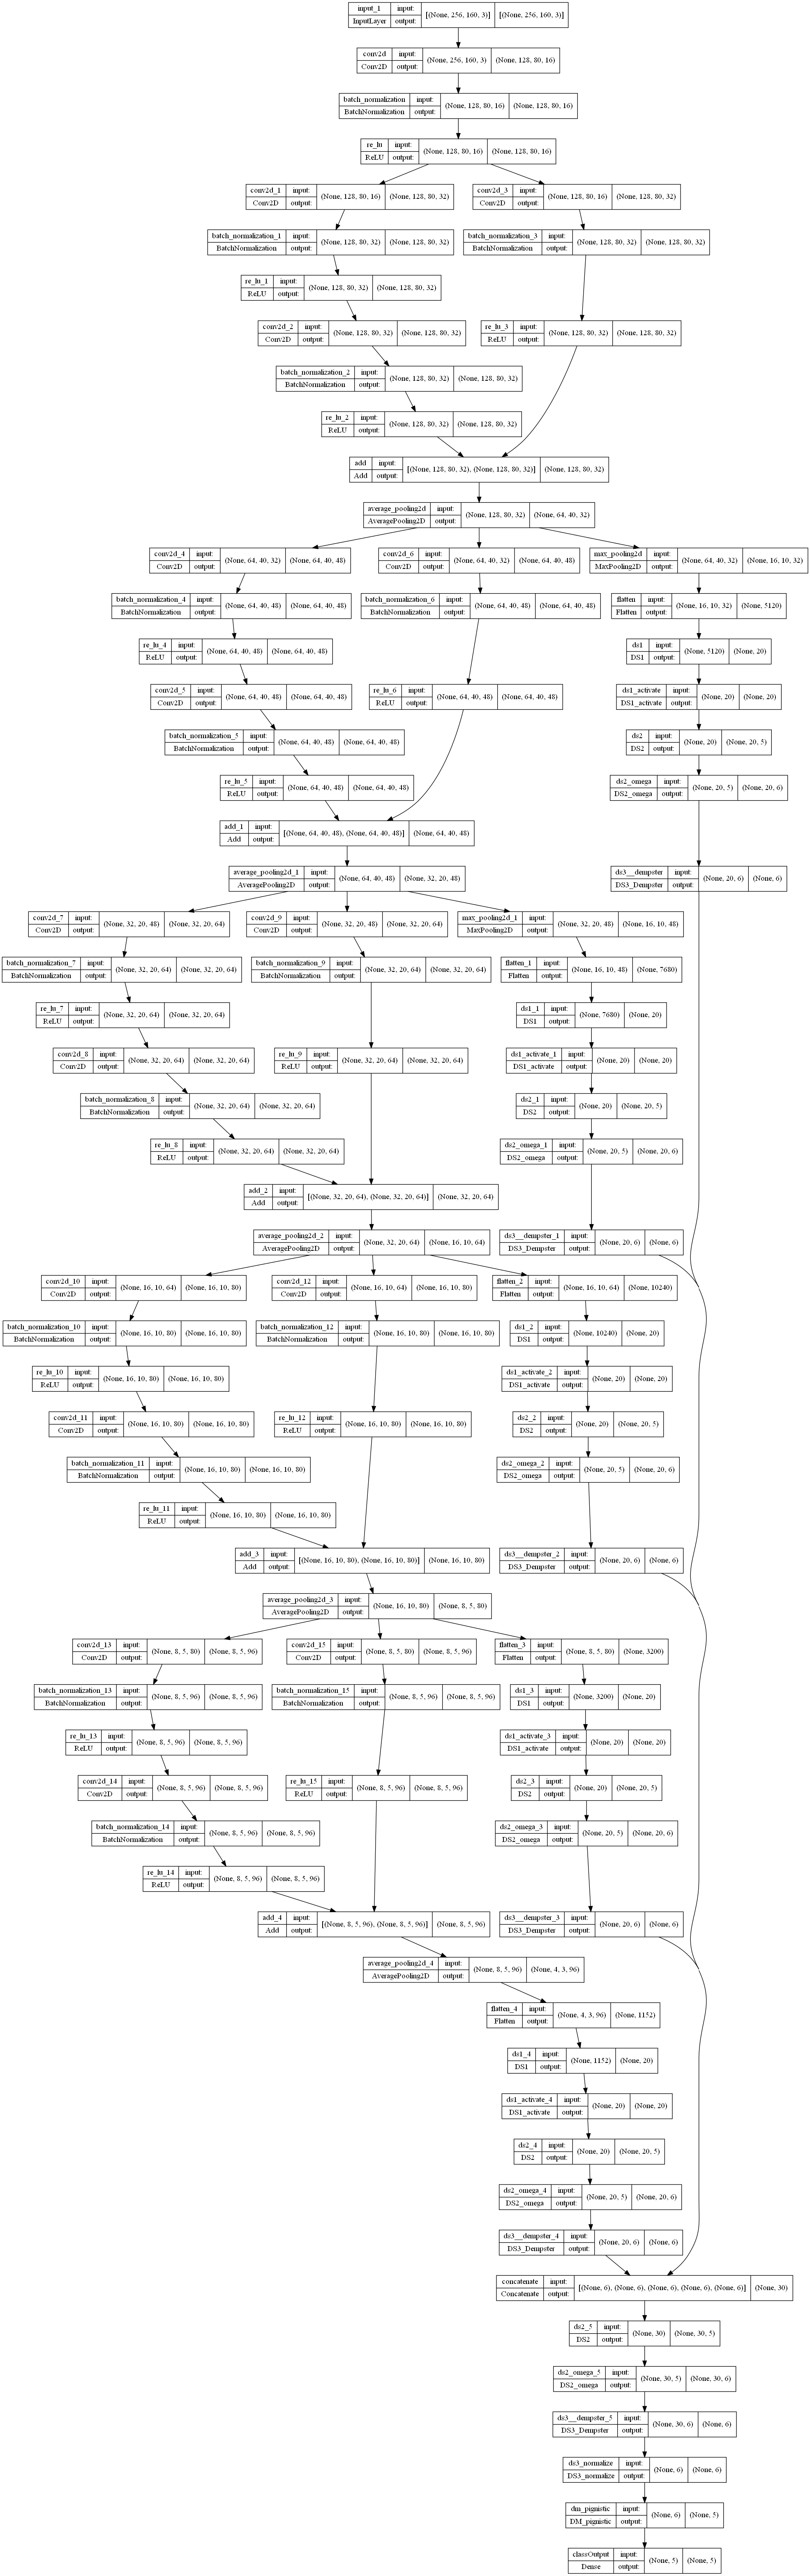

In [52]:
plot_model(modelDS, to_file=plotpath / Path('DS_Multilayer_model_plot_CLASSONLY.png'), show_shapes=True, show_layer_names=True)

In [53]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - (dice_coef(y_true,y_pred))

In [55]:
METRS = [
#     tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    tf.keras.metrics.Accuracy(name='accuracy'),
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#     tf.keras.metrics.Precision(name="precision"),
#     tf.keras.metrics.Recall(name="recall"),
#     tf.keras.metrics.TruePositives(name="True_Positives"),
#     tf.keras.metrics.TrueNegatives(name="True_Negatives"),
#     tf.keras.metrics.FalsePositives(name="False_Positives"),
#     tf.keras.metrics.FalseNegatives(name="False_Negatives"),
]

# def decay_lrate(initial_lrate, decay, iteration):
# 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

# initial_learning_rate = 0.0015
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False)

modelDS.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
        # optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(lr_schedule),
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-6),
        loss={
                'classOutput':"categorical_crossentropy",
                },
        metrics={
                'classOutput': 'categorical_accuracy',
                },
        # loss="hinge",
        # metrics=METRS,
)

# CREATE CALLBACKS
checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('model_DS_callback_DS_Classification'), 
						monitor='val_categorical_accuracy', verbose=1, 
						save_best_only=True, mode='max')
                                                # CREATE CALLBACKS

# callbacks_list = [checkpoint]
callbacks_list = [checkpointClassification]

history = modelDS.fit(
        x = X_train_IMGS,
        y = Y_train,
        epochs = 200,
        validation_data = [X_val_IMGS,Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=128,
)

# history = modelDS.fit(
#         x = trainset,
#         epochs = 300,
#         validation_data = valset,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
#         batch_size= 32,
#         # class_weight= class_weights
# )


Epoch 1/200
25/25 [==============================] - ETA: 0s - loss: 15.2794 - categorical_accuracy: 0.0064
Epoch 1: val_categorical_accuracy improved from -inf to 0.00772, saving model to ..\Outputs\CNN\CHECKPOINTS\CROPPED-DB\model_DS_callback_DS_Classification
INFO:tensorflow:Assets written to: ..\Outputs\CNN\CHECKPOINTS\CROPPED-DB\model_DS_callback_DS_Classification\assets
25/25 [==============================] - 39s 748ms/step - loss: 15.2794 - categorical_accuracy: 0.0064 - val_loss: 15.1969 - val_categorical_accuracy: 0.0077
Epoch 2/200
25/25 [==============================] - ETA: 0s - loss: 13.4652 - categorical_accuracy: 0.0685
Epoch 2: val_categorical_accuracy did not improve from 0.00772
25/25 [==============================] - 3s 119ms/step - loss: 13.4652 - categorical_accuracy: 0.0685 - val_loss: 15.1680 - val_categorical_accuracy: 0.0077
Epoch 3/200
25/25 [==============================] - ETA: 0s - loss: 7.7391 - categorical_accuracy: 0.3806
Epoch 3: val_categorical_acc

KeyboardInterrupt: 

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['categorical_accuracy'],
                    name='Train Classif eval'))
fig.add_trace(go.Scatter(
                    y=history.history['val_categorical_accuracy'],
                    name='Valid Classif eval'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

In [ ]:
# METRS = [
# #     tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
#     tf.keras.metrics.Accuracy(name='accuracy'),
#     tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
# #     tf.keras.metrics.Precision(name="precision"),
# #     tf.keras.metrics.Recall(name="recall"),
# #     tf.keras.metrics.TruePositives(name="True_Positives"),
# #     tf.keras.metrics.TrueNegatives(name="True_Negatives"),
# #     tf.keras.metrics.FalsePositives(name="False_Positives"),
# #     tf.keras.metrics.FalseNegatives(name="False_Negatives"),
# ]

# # def decay_lrate(initial_lrate, decay, iteration):
# # 	return initial_lrate * (1.0 / (1.0 + decay * iteration))

# # initial_learning_rate = 0.0015
# # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=False)

# modelDS.compile(
#         # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-02),
#         # optimizer=tf.keras.optimizers.Adam(),
#         # optimizer=tf.keras.optimizers.Adam(lr_schedule),
#         optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-6),
#         loss={
#                 'classOutput':"categorical_crossentropy",
#                 'maskOutput': dice_loss,
#                 # 'maskOutput':'binary_crossentropy',
#                 },
#         metrics={
#                 'classOutput': 'categorical_accuracy',
#                 # 'maskOutput': 'accuracy',
#                 'maskOutput': dice_coef,
#                 },
#         # loss="hinge",
#         # metrics=METRS,
# )

# # CREATE CALLBACKS
# checkpointClassification = tf.keras.callbacks.ModelCheckpoint(
# 						checkpointPath / Path('model_DS_callback_DS_Classification'), 
# 						monitor='val_classOutput_categorical_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
#                                                 # CREATE CALLBACKS
# checkpointSegmentation = tf.keras.callbacks.ModelCheckpoint(
# 						checkpointPath / Path('model_DS_callback_DS_Segmentation'), 
# 						monitor='val_maskOutput_dice_coef', verbose=1, 
# 						save_best_only=True, mode='max')

# # callbacks_list = [checkpoint]
# callbacks_list = [checkpointClassification,checkpointSegmentation]

# history = modelDS.fit(
#         x = X_train_IMGS,
#         y = [Y_train,Y_train_IMGS],
#         epochs = 200,
#         validation_data = [X_val_IMGS,[Y_val,Y_val_IMGS]],
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
#         batch_size=128,
# )

# # history = modelDS.fit(
# #         x = trainset,
# #         epochs = 300,
# #         validation_data = valset,
# #         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# #         batch_size= 32,
# #         # class_weight= class_weights
# # )


Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 1.0473 - classOutput_loss: 0.9208 - maskOutput_loss: 0.1265 - classOutput_categorical_accuracy: 0.7243 - maskOutput_dice_coef: 0.8793
Epoch 1: val_classOutput_categorical_accuracy improved from -inf to 0.73221, saving model to ..\Outputs\CNN\CHECKPOINTS\model_DS_callback_DS_Classification
INFO:tensorflow:Assets written to: ..\Outputs\CNN\CHECKPOINTS\model_DS_callback_DS_Classification\assets

Epoch 1: val_maskOutput_dice_coef improved from -inf to 0.06130, saving model to ..\Outputs\CNN\CHECKPOINTS\model_DS_callback_DS_Segmentation
INFO:tensorflow:Assets written to: ..\Outputs\CNN\CHECKPOINTS\model_DS_callback_DS_Segmentation\assets
45/45 [==============================] - 58s 852ms/step - loss: 1.0473 - classOutput_loss: 0.9208 - maskOutput_loss: 0.1265 - classOutput_categorical_accuracy: 0.7243 - maskOutput_dice_coef: 0.8793 - val_loss: 3.4896 - val_classOutput_loss: 2.5509 - val_maskOutput_loss: 0.9387 - val_classO

ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[128,128,256,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_6]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[128,128,256,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_70024]

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['classOutput_categorical_accuracy'],
                    name='Train Classif eval'))
fig.add_trace(go.Scatter(
                    y=history.history['val_classOutput_categorical_accuracy'],
                    name='Valid Classif eval'))
fig.add_trace(go.Scatter(
                    y=history.history['maskOutput_accuracy'],
                    name='Train Mask eval'))
fig.add_trace(go.Scatter(
                    y=history.history['val_maskOutput_accuracy'],
                    name='Valid Mask eval'))
fig.add_trace(go.Scatter(
                    y=history.history['maskOutput_dice_coef'],
                    name='Train Mask DICE'))
fig.add_trace(go.Scatter(
                    y=history.history['val_maskOutput_dice_coef'],
                    name='Valid Mask DICE'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
bestPt = checkpointPath / Path('model_DS_callback_DS_Segmentation')
model = tf.keras.models.load_model(bestPt)

In [ ]:
classes,masks = model.predict(X_val_IMGS)

In [ ]:
model.evaluate(X_val_IMGS,[Y_val,Y_val_IMGS])

45/45 [==============================] - 3s 24ms/step - loss: 4.4686 - classOutput_loss: 4.3050 - maskOutput_loss: 0.1636 - classOutput_categorical_accuracy: 0.7322 - maskOutput_dice_coef: 0.5264


[4.468608379364014,
 4.30497407913208,
 0.1636350452899933,
 0.7322058081626892,
 0.5264135599136353]

In [ ]:
masks[0].shape

(128, 256, 1)

In [ ]:
classes[0]

array([-0.06716807, -0.03565787,  0.26225436, -0.14870648], dtype=float32)

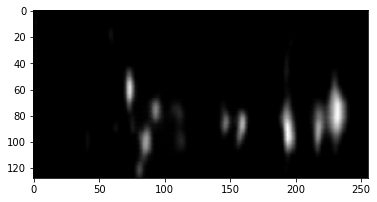

In [ ]:
plt.figure()
plt.imshow(masks[8],cmap='gray')

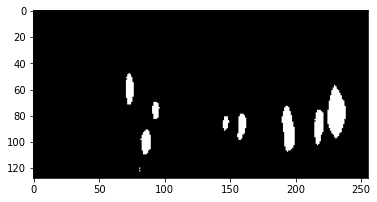

In [ ]:
plt.figure()
plt.imshow(masks[8]>0.2,cmap='gray')

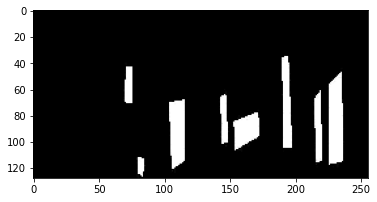

In [ ]:
plt.figure()
plt.imshow(Y_val_IMGS[8], cmap='gray')

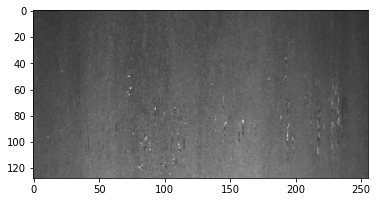

In [ ]:
plt.figure()
plt.imshow(X_val_IMGS[8])

### Video systems

In [ ]:
vsPathX = Path('../DB/Video-Systems/labelled/db/X/')
vsPathY = Path('../DB/Video-Systems/labelled/db/Y/')

In [ ]:
def gray_to_rgb(img):
    return np.repeat(img, 3, 2)

In [ ]:
vsX = []
resize = True
for (dirpath, dirnames, filenames) in os.walk(vsPathX):
    for p in tqdm(filenames):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = dirpath / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),color_mode='grayscale')
            img = np.expand_dims(img, axis=-1)
            img = gray_to_rgb(img)
        else:
            img = load_img(fullPath)
        vsX.append(img)
vsX = np.array([np.array(fname) for fname in vsX])  #transform each element of list in numpy array    
vsY = []
resize = True
for (dirpath, dirnames, filenames) in os.walk(vsPathY):
    for p in tqdm(filenames):
        p = Path(p)
        # print(p)
        # fullPath = Path(str(basePath) + str(p))
        fullPath = dirpath / p
        # print(basePath)
        # print(fullPath)
        if resize:
            img = load_img(fullPath,target_size=(IMAGE_SIZE[0],IMAGE_SIZE[1]))
        else:
            img = load_img(fullPath)
        vsY.append(img)
vsY = np.array([np.array(fname) for fname in vsY])  #transform each element of list in numpy array    

100%|██████████| 80/80 [00:00<00:00, 139.84it/s]


In [ ]:
vsX.shape

(80, 128, 256, 3)

In [ ]:
# normalization
vsX = vsX.astype('float32')/255.0
vsY = vsY.astype('float32')/255.0

In [ ]:
classes,masks = model.predict(vsX)

In [ ]:
masks.shape

(80, 128, 256, 1)

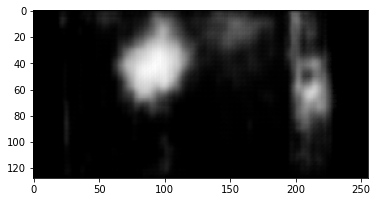

In [ ]:
plt.figure()
plt.imshow(masks[10],cmap='gray')

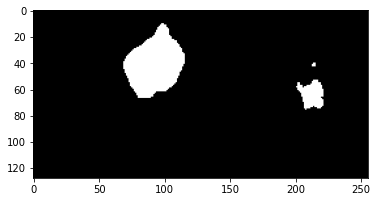

In [ ]:
plt.figure()
plt.imshow(masks[10]>0.5,cmap='gray')

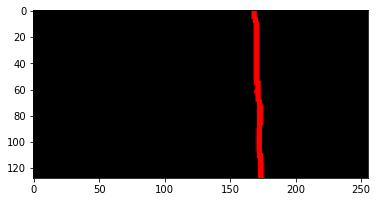

In [ ]:
plt.figure()
plt.imshow(vsY[10], cmap='gray')

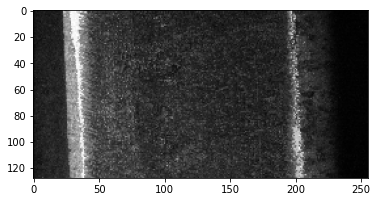

In [ ]:
plt.figure()
plt.imshow(vsX[10])

## COVID 2D segmentation

In [ ]:
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Normalization
from keras.layers.merge import concatenate

In [ ]:
def segModel2D(inp_shape,k_size = 3,merge_axis = -1):
    data = Input(shape=inp_shape)
    # norm = Normalization(axis=-1)(data)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(data)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(merged4)

    conv10 = Convolution2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)

    output = conv10
    model = Model(data, output)
    return model

In [ ]:
model = segModel2D((IMAGE_SIZE[0],IMAGE_SIZE[1],3))

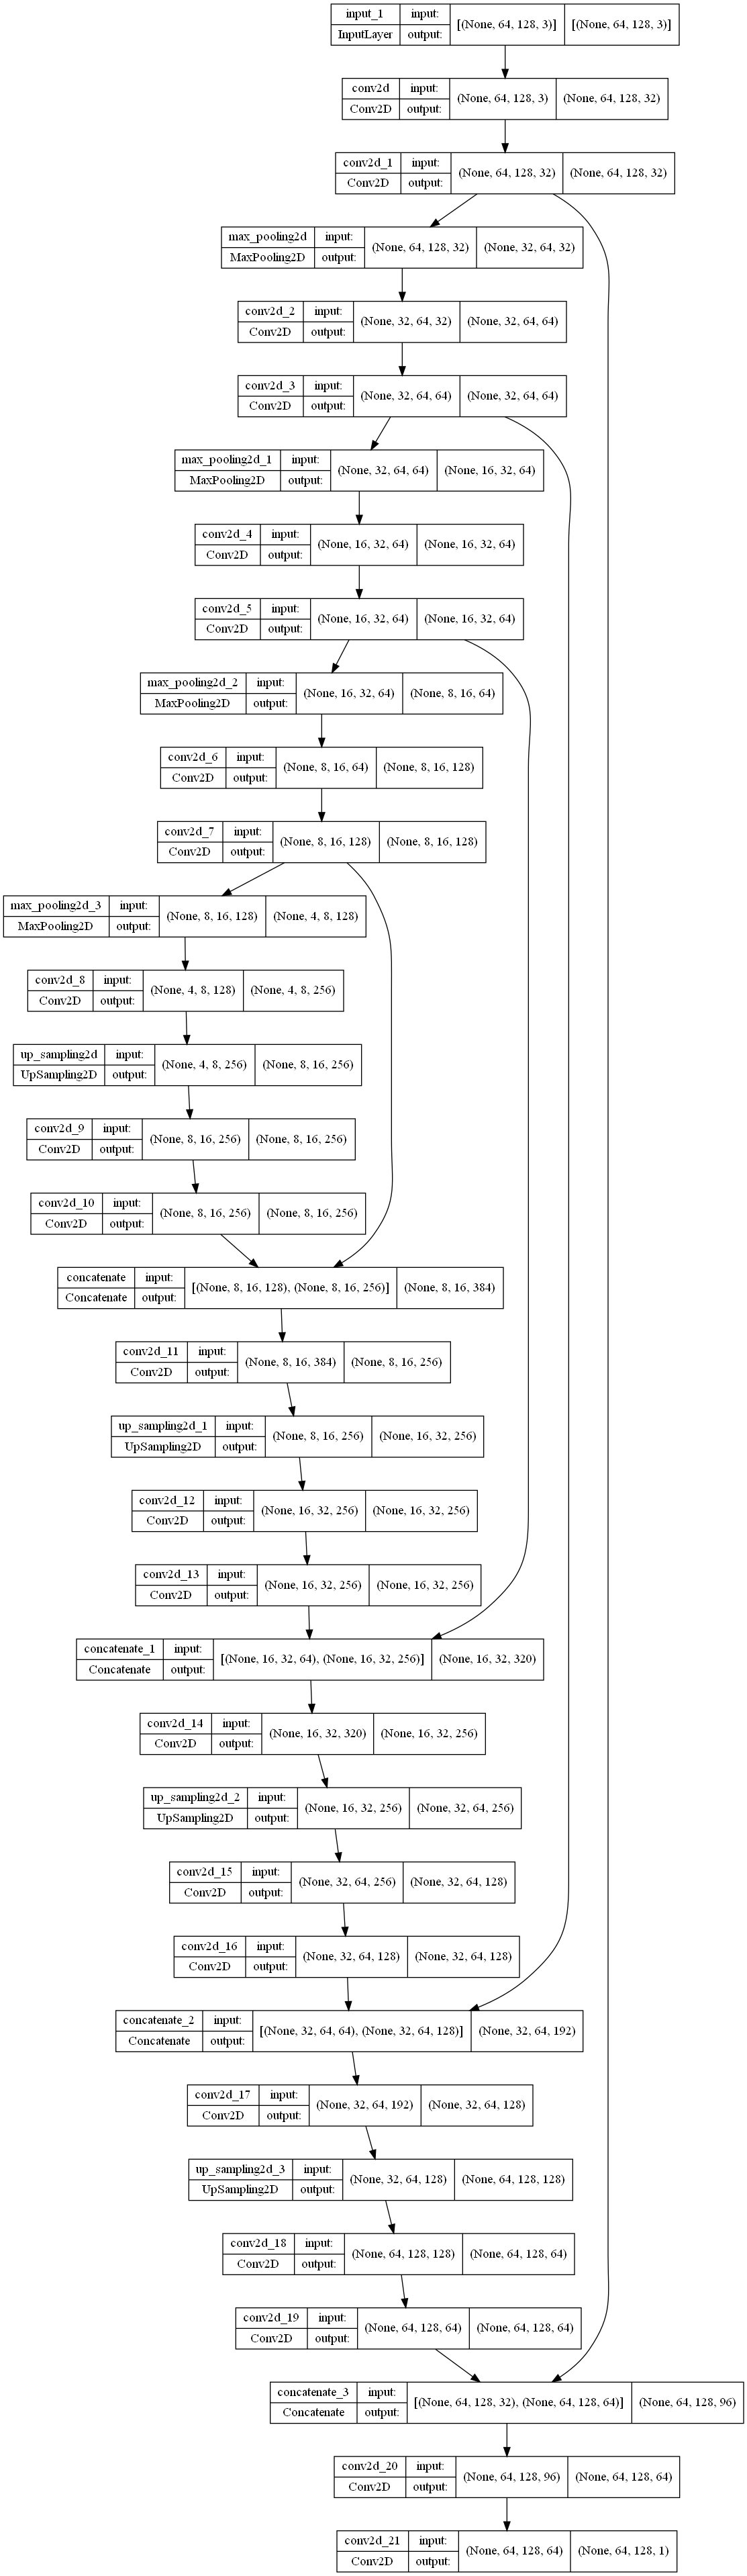

In [ ]:
plot_model(model, to_file=plotpath / Path('Segmentation2D_fromCovid.png'), show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="binary_crossentropy",
        metrics=['accuracy'],
)

In [ ]:
# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('segmentationModel'), 
						monitor='val_accuracy', verbose=1, 
						save_best_only=True, mode='max')

callbacks_list = [checkpoint]

history = model.fit(
        x = X_train_IMGS,
        y = Y_train_IMGS,
        epochs = 50,
        validation_data = [X_val_IMGS,Y_val_IMGS],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
        batch_size=64,
)


Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9274
Epoch 1: val_accuracy improved from -inf to 0.93806, saving model to ..\Outputs\CNN\CHECKPOINTS\segmentationModel
INFO:tensorflow:Assets written to: ..\Outputs\CNN\CHECKPOINTS\segmentationModel\assets
89/89 [==============================] - 16s 130ms/step - loss: 0.2343 - accuracy: 0.9274 - val_loss: 0.1648 - val_accuracy: 0.9381
Epoch 2/50
89/89 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9418
Epoch 2: val_accuracy improved from 0.93806 to 0.94594, saving model to ..\Outputs\CNN\CHECKPOINTS\segmentationModel
INFO:tensorflow:Assets written to: ..\Outputs\CNN\CHECKPOINTS\segmentationModel\assets
89/89 [==============================] - 9s 104ms/step - loss: 0.1627 - accuracy: 0.9418 - val_loss: 0.1500 - val_accuracy: 0.9459
Epoch 3/50
89/89 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9448
Epoch 3: val_accuracy improved from 0.94594 to 0.9

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train segmentation loss'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Valid segmentation loss'))
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train segmentation accuracy'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Valid segmentation accuracy'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
p = model.predict(X_val_IMGS)

In [ ]:
p[0]

array([[[1.1665915e-05],
        [2.0707385e-07],
        [8.1087578e-08],
        ...,
        [1.5917186e-06],
        [1.3662637e-06],
        [1.6382501e-05]],

       [[1.3344156e-06],
        [2.8508603e-07],
        [5.7894560e-08],
        ...,
        [1.5857626e-06],
        [1.1792745e-06],
        [5.4786574e-06]],

       [[2.2675802e-07],
        [1.6330883e-07],
        [4.3768090e-08],
        ...,
        [1.5229886e-06],
        [5.9791091e-07],
        [1.6120025e-06]],

       ...,

       [[3.9640179e-07],
        [3.9104930e-07],
        [2.8846964e-07],
        ...,
        [7.7450339e-04],
        [1.3368420e-03],
        [3.1011412e-03]],

       [[7.0538767e-06],
        [2.3944212e-06],
        [1.6325371e-06],
        ...,
        [6.6460279e-04],
        [1.2780074e-03],
        [2.2056261e-03]],

       [[5.3518575e-05],
        [6.2167064e-06],
        [3.0112999e-06],
        ...,
        [2.2225673e-04],
        [4.9922254e-04],
        [2.8687501e-03]]

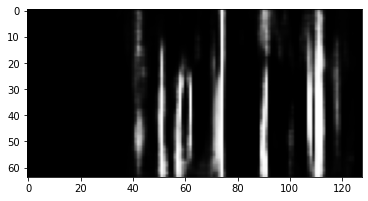

In [ ]:
plt.figure()
plt.imshow(p[1],cmap='gray')

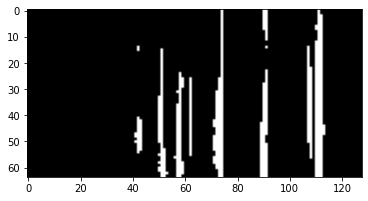

In [ ]:
plt.figure()
plt.imshow(p[1]>0.5,cmap='gray')

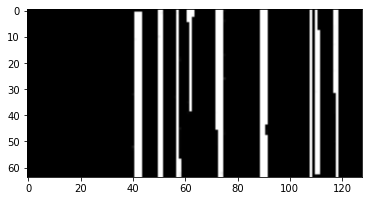

In [ ]:
plt.figure()
plt.imshow(Y_val_IMGS[1], cmap='gray')

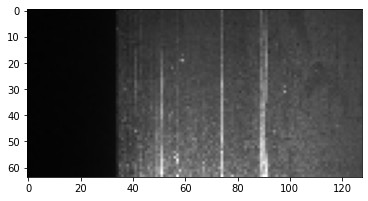

In [ ]:
plt.figure()
plt.imshow(X_val_IMGS[1])